In [1]:
### Written for CAMP 2016 tutorial
### Adapted from Vogels 2011
### Author: Harsha Gurnani
### Date: June 18, 2016

#####################################

In [2]:
from brian2 import *
from time import time

from numpy import *
from scipy import *
from inputsignals import *
from spikegen import *

from inputsignals import *
%matplotlib inline
#set_device('cpp_standalone')

### Simulation parameters
simtime = 10*second
delta = 0.1*ms
tlen = int(simtime/delta)

defaultclock.dt = delta

###  Model Parameters

In [3]:
### LIF neuron
taum = 20*ms                	#Mem time constant
Vrest = Vr = -60*mV         	#Rest and reset voltage
Vt = -50*mV                 	#Spiking threshold
taur = 5*ms                 	#Refractory period
Rm = 100*Mohm               	#Membrane resistance
gleak = 10*nsiemens         	#Leak conductance = 1/Rm

In [4]:
### Synaptic parameters
gmax = 5*140*psiemens         	#For AMPAr
ginh = 350*psiemens         	#For GABAr
Ve = 0*mV                   	#AMPAr reversal
Vi = -80*mV                 	#GABAr reversal
taue = 5*ms                 	#AMPAr timeconstant
taui = 10*ms                	#GABAr timeconstant
Ib = 0*pamp                 	#Baseline current 

TotalN = 1000               	#Total no. of synapses
Ne = int(0.8*TotalN)        	#No. of exc. synapses = 80% of Total
Ni = int(0.2*TotalN)        	#No. of inh synapses = 20% of Total
ngr = 8                     	#No. of groups/signals

In [5]:
### STDP parameters
tau_STDP = 20*ms
eta = 0.0001                #Learning rate
rho0 = 5*Hz
alpha = 2*rho0*tau_STDP     #Depression factor

## nsiemens unit cannot be used inside equations block. hence will use gw to divide conductances to
## make them unitless.
gw = 1*nsiemens

In [6]:
### Neuron model
eqs = Equations('''
    dV/dt = ((Vrest - V) + 1/gleak*( gw*ge*(Ve-V) +gw*gi*(Vi-V) + Ib ))/taum :volt
    dge/dt = -ge/taue : 1
    dgi/dt = -gi/taui :1
    dx/dt = -x/tau_STDP :1
    ie = ge*(Vi-V) :volt
    ii = gi* (Ve-V) :volt
''')

G = NeuronGroup(1, model=eqs, threshold='V>Vt', reset='V=Vrest; x+= 1', refractory=taur, method='euler')

### Synaptic dynamics

In [7]:
## Generate 8 different input signals for 8 groups of synapses:

#####
### Artificial Neuron Group:
###This procedure was executed by CreateInputSpikeTrains.py
### Run that file again to generate new signals. Or uncomment the following and then comment the next line.
# InpSignals = GenerateInputSignalForGroup( ngr, arange(0,simtime/delta,delta), delta)
#####

InpSignals = np.load('inputs.npy')
s1=TimedArray(InpSignals.transpose(),dt=delta)

In [8]:
## Excitatory synapses

##Presynaptic firing:
exceq = '''
    rate1 = s1(t,i/ngr) :1
    '''
Exc_Inp = NeuronGroup(Ne, exceq, threshold='rand()<rate1')

## Synapse model
syne_eqs = '''
    We :1
    '''
preeqns = '''
    ge_post += We*gmax/gw
    '''

AMPA = Synapses( Exc_Inp, G, model=syne_eqs, on_pre=preeqns )
AMPA.connect()

## Different synaptic weights for different groups
##Seting excitatory weights : Different for each group
P = int(ngr/2)+0.1
maxw = 2.2
Negrp = int(Ne/ngr)
minw = 0.3
for ii in range(Ne):
    grp = int(ii/Negrp)
    AMPA.We[ii] = min(minw + maxw/(1.0+(grp-P))**4 ,0.6)+ 0.1*rand()

 

In [9]:
### Inhibitory synapses:


inheq = '''
    rate2 = s1(t,i/ngr) :1
    '''
Inh_Inp = NeuronGroup(Ni, inheq, threshold='rand()<rate2')
#InhData = np.load('spiketrain_inh.npy')
#Inh_Inp = SpikeGeneratorGroup(Ni, InhData[:,0], InhData[:,1]*second, sorted=True)		#Providing spiketimes at synapse	
syni_eqs = '''
    Wi :1
    dy/dt = -y/tau_STDP :1	(event-driven)
    '''
syni_pre = '''
    gi_post += Wi*ginh/gw
    y += 1
    Wi += eta*(x_post - alpha)
 '''   
syni_post = '''
    Wi += eta*y
 '''

 
#Synapse:
GABA = Synapses( Inh_Inp, G, model=syni_eqs, on_pre=syni_pre, on_post=syni_post )
GABA.connect()
Nigrp = int(Ni/ngr)
GABA.Wi[:] = 0.1

### Monitors and Run

In [10]:
SpE= SpikeMonitor(Exc_Inp)
SpI= SpikeMonitor(Inh_Inp)
CellSpk= SpikeMonitor(G)

ExcCurrent = StateMonitor(G, 'ie', record=True)
InhCurrent = StateMonitor(G, 'ii', record=True)

ExcWt = StateMonitor(AMPA,'We', record=[0,Ne/2, Ne-1])
InhWt = StateMonitor(GABA,'Wi', record=[0,Ni/2, Ni-1])

## Run
run(simtime, report='text')

### Net Current:
DiffCurrent = ExcCurrent.ie + InhCurrent.ii

Starting simulation at t=0. s for a duration of 10. s
2.808 s (28%) simulated in 10s, estimated 26s remaining.
5.6126 s (56%) simulated in 20s, estimated 16s remaining.
8.2915 s (82%) simulated in 30s, estimated 6s remaining.
10. s (100%) simulated in 36s


### Plotting

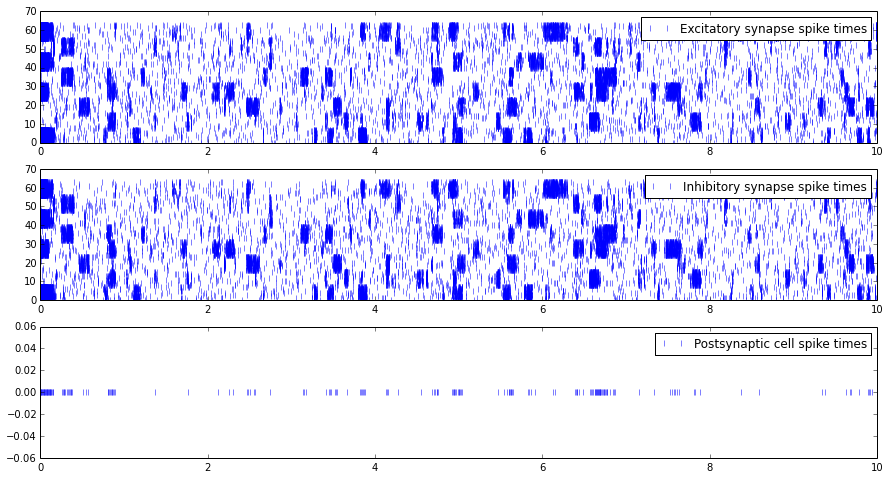

In [11]:
### Raster plot for exc and inh "cells", amd postsynaptic cell

figure(figsize=[15,8])
subplot(311)
plot(SpE.t/second, SpE.i, '|', label='Excitatory synapse spike times')
legend()
subplot(312)
plot(SpI.t/second, SpI.i, '|', label='Inhibitory synapse spike times')
legend()
subplot(313)
plot(CellSpk.t/second, CellSpk.i, '|', label='Postsynaptic cell spike times')
legend()


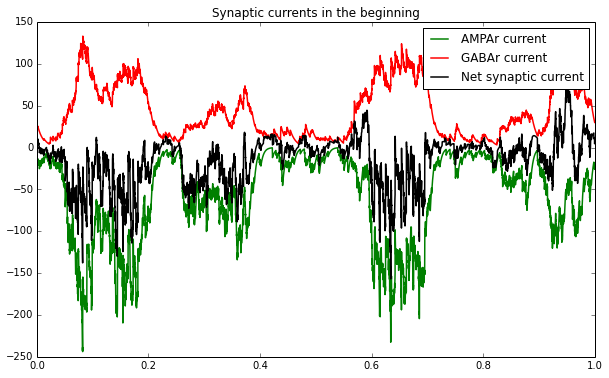

In [16]:
### Initial synaptic currents:
figure(figsize=[10,6])
plot(range(10000)*delta/second, ExcCurrent.ie[0,2000:12000]/mV, 'g', linewidth=1.5,label='AMPAr current')
plot(range(10000)*delta/second, InhCurrent.ii[0,2000:12000]/mV, 'r', linewidth=1.5,label='GABAr current')
plot(range(10000)*delta/second, DiffCurrent[0,2000:12000]/mV, 'k', linewidth=1.5,label='Net synaptic current')
title('Synaptic currents in the beginning')
legend()


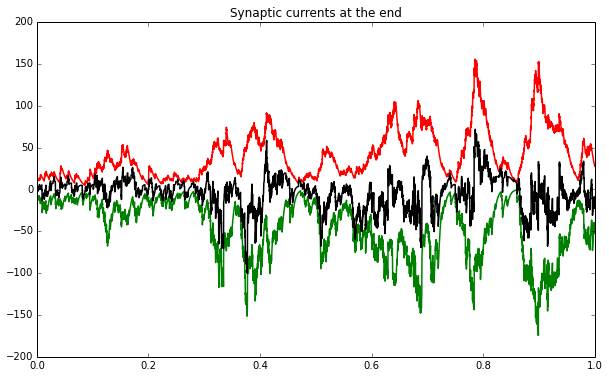

In [17]:
maxt=int(simtime/ms)
### Final synaptic currents:maxt=int(simtime/ms)
figure(figsize=[10,6])
plot(range(maxt-10000,maxt)*delta/second, ExcCurrent.ie[0,-10000:]/mV,'g', linewidth=1.5)
plot(range(maxt-10000,maxt)*delta/second, InhCurrent.ii[0,-10000:]/mV, 'r',linewidth=1.5)
plot(range(maxt-10000,maxt)*delta/second, DiffCurrent[0,-10000:]/mV, 'k',linewidth=1.5)
title('Synaptic currents at the end')
